# ResNet152 전이학습 ver1
- 0,3,6 라벨 3000장씩 증강.

In [ ]:
weights = class_weight.compute_class_weight(class_weight = "balanced" , 
                                  classes=np.unique(test_labels), 
                                  y = test_labels)

weights = {i : weights[i] for i in range(7)}
weights

{0: 4.455357142857143,
 1: 2.795518207282913,
 2: 1.307994757536042,
 3: 12.96103896103896,
 4: 1.2844272844272844,
 5: 0.21279317697228145,
 6: 10.183673469387756}

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label

# def preprocessing(image, label):
#     re_image = tf.image.resize(image, [224,224,3])
#     # re_image = re_image/255.0
#     final_image = tf.keras.applications.resnet.preprocess_input(re_image) 
#     # final_image = final_image/255.0
#     return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

Epoch 1/200
901/901 [==============================] - ETA: 0s - loss: 0.7139 - accuracy: 0.7589
Epoch 1: val_loss improved from inf to 0.49777, saving model to /content/drive/MyDrive/skincancer_resnet152.h5
901/901 [==============================] - 151s 158ms/step - loss: 0.7139 - accuracy: 0.7589 - val_loss: 0.4978 - val_accuracy: 0.8382 - lr: 0.0010
Epoch 2/200
901/901 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.8444
Epoch 2: val_loss improved from 0.49777 to 0.43212, saving model to /content/drive/MyDrive/skincancer_resnet152.h5
901/901 [==============================] - 162s 180ms/step - loss: 0.4668 - accuracy: 0.8444 - val_loss: 0.4321 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 3/200
901/901 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8685
Epoch 3: val_loss did not improve from 0.43212
901/901 [==============================] - 156s 173ms/step - loss: 0.3887 - accuracy: 0.8685 - val_loss: 0.4823 - val_accuracy: 0.8441 - lr:

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152.h5')

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 13s 173ms/step - loss: 0.6963 - accuracy: 0.7966


[0.6963441967964172, 0.796593189239502]

In [ ]:

def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 12s 157ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.6518
재현율 : 0.6566
f1_score : 0.6542
balanced_accuracy_score :  0.6566


### y_train class_weight 기준 학습


In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label


weights = class_weight.compute_class_weight(class_weight = "balanced" , 
                                  classes=np.unique(y_train), 
                                  y = y_train)

weights = {i : weights[i] for i in range(7)}
# weights

# def preprocessing(image, label):
#     re_image = tf.image.resize(image, [224,224,3])
#     # re_image = re_image/255.0
#     final_image = tf.keras.applications.resnet.preprocess_input(re_image) 
#     # final_image = final_image/255.0
#     return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_weighted_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, class_weight=weights, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 8s 0us/step
Epoch 1/200
901/901 [==============================] - ETA: 0s - loss: 1.0363 - accuracy: 0.6704
Epoch 1: val_loss improved from inf to 0.80760, saving model to /content/drive/MyDrive/skincancer_weighted_resnet152.h5
901/901 [==============================] - 157s 156ms/step - loss: 1.0363 - accuracy: 0.6704 - val_loss: 0.8076 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 2/200
901/901 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.7783
Epoch 2: val_loss improved from 0.80760 to 0.71260, saving model to /content/drive/MyDrive/skincancer_weighted_resnet152.h5
901/901 [==============================] - 154s 171ms/step - loss: 0.6979 - accuracy: 0.7783 - val_loss: 0.7126 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 3/200
901/901 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.8165
Epoch 3: val_loss improved from 0.71260 to 0.61156, saving model to /content/drive/MyDrive/skincancer_

In [ ]:
ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label

batch_size = 16

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_weighted_resnet152.h5')

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 22s 147ms/step - loss: 0.7391 - accuracy: 0.7796


[0.7391407489776611, 0.7795591354370117]

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 11s 132ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.5678
재현율 : 0.6597
f1_score : 0.6103
balanced_accuracy_score :  0.6597


### 원본 데이터셋 y_train class_weight 학습

In [ ]:
main_path = '/content/images/'

train_paths, test_paths = [], []

for filename in train_df.image:
  train_paths.append(main_path + filename + '.jpg')

for filename in test_df.image:
  test_paths.append(main_path + filename + '.jpg')

train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

train_labels = train_df.label.values
test_labels = test_df.label.values

len(train_paths), len(train_labels), len(test_paths), len(test_labels)

(9017, 9017, 998, 998)

In [ ]:
s = np.arange(len(train_paths))
np.random.shuffle(s)

train_paths = train_paths[s]
train_labels = train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

weights = class_weight.compute_class_weight(class_weight = "balanced" , 
                                  classes=np.unique(y_train), 
                                  y = y_train)

weights = {i : weights[i] for i in range(7)}
# weights


batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)

resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_noaug_weighted_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, class_weight=weights, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 1s 0us/step
Epoch 1/200
451/451 [==============================] - ETA: 0s - loss: 1.4541 - accuracy: 0.5314
Epoch 1: val_loss improved from inf to 1.36428, saving model to /content/drive/MyDrive/skincancer_noaug_weighted_resnet152.h5
451/451 [==============================] - 96s 194ms/step - loss: 1.4541 - accuracy: 0.5314 - val_loss: 1.3643 - val_accuracy: 0.4906 - lr: 0.0010
Epoch 2/200
451/451 [==============================] - ETA: 0s - loss: 0.9262 - accuracy: 0.6587
Epoch 2: val_loss improved from 1.36428 to 0.90759, saving model to /content/drive/MyDrive/skincancer_noaug_weighted_resnet152.h5
451/451 [==============================] - 92s 205ms/step - loss: 0.9262 - accuracy: 0.6587 - val_loss: 0.9076 - val_accuracy: 0.6657 - lr: 0.0010
Epoch 3/200
451/451 [==============================] - ETA: 0s - loss: 0.8210 - accuracy: 0.6872
Epoch 3: val_loss did not improve from 0.90759
451/451 [==============================] - 71

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 18s 276ms/step - loss: 0.6791 - accuracy: 0.7655


[0.6791227459907532, 0.765531063079834]

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

63/63 [==============================] - 13s 133ms/step
정밀도 : 0.5896
재현율 : 0.6266
f1_score : 0.6076
balanced_accuracy_score :  0.6266


### 원본 데이터셋 ResNet152 학습

In [ ]:
s = np.arange(len(train_paths))
np.random.shuffle(s)

train_paths = train_paths[s]
train_labels = train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

# weights = class_weight.compute_class_weight(class_weight = "balanced" , 
#                                   classes=np.unique(y_train), 
#                                   y = y_train)

# weights = {i : weights[i] for i in range(7)}
# weights


batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)

resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_noaug_resnet152.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

Epoch 1/200
451/451 [==============================] - ETA: 0s - loss: 0.8066 - accuracy: 0.7242
Epoch 1: val_loss improved from inf to 0.67031, saving model to /content/drive/MyDrive/skincancer_noaug_resnet152.h5
451/451 [==============================] - 86s 171ms/step - loss: 0.8066 - accuracy: 0.7242 - val_loss: 0.6703 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 2/200
451/451 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.7864
Epoch 2: val_loss improved from 0.67031 to 0.66962, saving model to /content/drive/MyDrive/skincancer_noaug_resnet152.h5
451/451 [==============================] - 76s 169ms/step - loss: 0.5883 - accuracy: 0.7864 - val_loss: 0.6696 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 3/200
451/451 [==============================] - ETA: 0s - loss: 0.5264 - accuracy: 0.8085
Epoch 3: val_loss improved from 0.66962 to 0.62369, saving model to /content/drive/MyDrive/skincancer_noaug_resnet152.h5
451/451 [==============================] - 79s 174ms/ste

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 10s 148ms/step - loss: 0.5940 - accuracy: 0.8006


[0.5939986705780029, 0.8006011843681335]

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

63/63 [==============================] - 11s 135ms/step
정밀도 : 0.6814
재현율 : 0.5556
f1_score : 0.6121
balanced_accuracy_score :  0.5556


# ResNet152 전이학습 ver2
- 5번 NV 제외한 모든 라벨 3000장씩 증강.

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label

# def preprocessing(image, label):
#     re_image = tf.image.resize(image, [224,224,3])
#     # re_image = re_image/255.0
#     final_image = tf.keras.applications.resnet.preprocess_input(re_image) 
#     # final_image = final_image/255.0
#     return final_image, label

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_resnet152_ver2.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 9s 0us/step
Epoch 1/200
1351/1351 [==============================] - ETA: 0s - loss: 0.9244 - accuracy: 0.6572
Epoch 1: val_loss improved from inf to 0.70449, saving model to /content/drive/MyDrive/skincancer_resnet152_ver2.h5
1351/1351 [==============================] - 232s 160ms/step - loss: 0.9244 - accuracy: 0.6572 - val_loss: 0.7045 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 2/200
1351/1351 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.7649
Epoch 2: val_loss improved from 0.70449 to 0.61390, saving model to /content/drive/MyDrive/skincancer_resnet152_ver2.h5
1351/1351 [==============================] - 222s 165ms/step - loss: 0.6357 - accuracy: 0.7649 - val_loss: 0.6139 - val_accuracy: 0.7728 - lr: 0.0010
Epoch 3/200
1351/1351 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.7997
Epoch 3: val_loss improved from 0.61390 to 0.52858, saving model to /content/drive/MyDrive/skincance

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 11s 175ms/step - loss: 0.6732 - accuracy: 0.8016


[0.6732069849967957, 0.8016031980514526]

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver2.h5')

In [ ]:

def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 13s 129ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.6428
재현율 : 0.6377
f1_score : 0.6402
balanced_accuracy_score :  0.6377


# ResNet152 전이학습 ver3
- 5번 NV 제외한 모든 라벨 약 5000장까지 증강

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#############################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label


batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)

base_model = keras.applications.ResNet152(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)


resnet152 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_resnet152_ver3.h5', monitor='val_loss', verbose=1, save_best_only=True)

resnet152.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = resnet152.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

234698864/234698864 [==============================] - 2s 0us/step
Epoch 1/200
1851/1851 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6851
Epoch 1: val_loss improved from inf to 0.64157, saving model to /content/drive/MyDrive/skincancer_resnet152_ver3.h5
1851/1851 [==============================] - 310s 158ms/step - loss: 0.8523 - accuracy: 0.6851 - val_loss: 0.6416 - val_accuracy: 0.7635 - lr: 0.0010
Epoch 2/200
1851/1851 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.7914
Epoch 2: val_loss improved from 0.64157 to 0.53770, saving model to /content/drive/MyDrive/skincancer_resnet152_ver3.h5
1851/1851 [==============================] - 294s 159ms/step - loss: 0.5766 - accuracy: 0.7914 - val_loss: 0.5377 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 3/200
1851/1851 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8233
Epoch 3: val_loss improved from 0.53770 to 0.48271, saving model to /content/drive/MyDrive/skincance

In [ ]:
resnet152.evaluate(test_dataset)

63/63 [==============================] - 22s 163ms/step - loss: 0.8573 - accuracy: 0.7715


[0.8572513461112976, 0.7715430855751038]

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver3.h5')

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16


pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

y_pred = resnet152.predict(pred_test_dataset)
label_pred = np.argmax(y_pred, axis=1)

63/63 [==============================] - 11s 130ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.5938
재현율 : 0.6458
f1_score : 0.6187
balanced_accuracy_score :  0.6458


# Inceptionv3 전이학습
- 0,3,6번 라벨 3000장 증강

In [ ]:
s = np.arange(len(aug_train_paths))
np.random.shuffle(s)

train_paths = aug_train_paths[s]
train_labels = aug_train_labels[s]
X_train, X_val, y_train, y_val = train_test_split(train_paths, train_labels, test_size=0.2, random_state=42)
#######################################################################################################################################

ss = s = np.arange(len(test_paths))
np.random.shuffle(ss)

test_paths = test_paths[ss]
test_labels = test_labels[ss]

def preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img, label
#######################################################################################################################################

batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

train_dataset = train_dataset.shuffle(len(aug_train_paths))
train_dataset = train_dataset.map(preprocessing).batch(batch_size).prefetch(1)
val_dataset = val_dataset.map(preprocessing).batch(batch_size).prefetch(1)
test_dataset = test_dataset.map(preprocessing).batch(batch_size).prefetch(1)
#######################################################################################################################################
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)
gap = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(7, activation='softmax')(gap)

InceptionV3 = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
#######################################################################################################################################
optimizer = keras.optimizers.Adam()
loss = keras.losses.SparseCategoricalCrossentropy()

es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=8)
mc = ModelCheckpoint('/content/drive/MyDrive/skincancer_Inceptionv3.h5', monitor='val_loss', verbose=1, save_best_only=True)
#######################################################################################################################################
InceptionV3.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = InceptionV3.fit(train_dataset, validation_data = val_dataset, epochs=200, verbose=1, callbacks=[es, reduce_lr, mc])

87910968/87910968 [==============================] - 4s 0us/step
Epoch 1/200
901/901 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.7100
Epoch 1: val_loss improved from inf to 0.69919, saving model to /content/drive/MyDrive/skincancer_Inceptionv3.h5
901/901 [==============================] - 98s 95ms/step - loss: 0.8583 - accuracy: 0.7100 - val_loss: 0.6992 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 2/200
901/901 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.7917
Epoch 2: val_loss improved from 0.69919 to 0.59689, saving model to /content/drive/MyDrive/skincancer_Inceptionv3.h5
901/901 [==============================] - 85s 94ms/step - loss: 0.6139 - accuracy: 0.7917 - val_loss: 0.5969 - val_accuracy: 0.7977 - lr: 0.0010
Epoch 3/200
901/901 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.8174
Epoch 3: val_loss improved from 0.59689 to 0.55104, saving model to /content/drive/MyDrive/skincancer_Inceptionv3.h5
901/9

# ResNet152 앙상블

In [ ]:
resnet152 = keras.models.load_model('/content/drive/MyDrive/skincancer_weighted_resnet152.h5')
resnet152_2 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152.h5')
resnet152_3 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver2.h5')
resnet152_4 = keras.models.load_model('/content/drive/MyDrive/skincancer_resnet152_ver3.h5')

In [ ]:
def pred_preprocessing(path, label):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, (224,224))
  img = tf.keras.applications.resnet.preprocess_input(img)
#   img = img/255 # ResNet152는 -1~1 제로센터링을 입력받는걸로 기억한다. 
  return img

batch_size = 16

pred_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
pred_test_dataset = pred_test_dataset.map(pred_preprocessing).batch(batch_size).prefetch(1)

models = [resnet152, resnet152_2, resnet152_3, resnet152_4]
y_pred = [model.predict(pred_test_dataset) for model in models]
pred_sum = np.sum(y_pred, axis=0)
label_pred = np.argmax(pred_sum, axis=1)

63/63 [==============================] - 11s 127ms/step


In [ ]:
precision = precision_score(test_labels, label_pred, average='macro')
recall = recall_score(test_labels, label_pred, average= "macro")
F1 = 2 * (precision * recall) / (precision + recall)
balanced_acc_score = balanced_accuracy_score(test_labels, label_pred)


print(f'정밀도 : {precision:.4f}')
print(f'재현율 : {recall:.4f}')
print(f'f1_score : {F1:.4f}')
print(f'balanced_accuracy_score : {balanced_acc_score: .4f}')

정밀도 : 0.6237
재현율 : 0.6552
f1_score : 0.6390
balanced_accuracy_score :  0.6552


In [ ]:
cm = confusion_matrix(test_labels, label_pred)
cm

array([[ 17,   5,   5,   0,   5,   0,   0],
       [  6,  31,   6,   2,   0,   6,   0],
       [  6,   2,  64,   3,  17,  17,   0],
       [  0,   0,   0,   9,   1,   1,   0],
       [  2,   2,  20,   0,  45,  39,   3],
       [  1,   6,  10,   2,  31, 618,   2],
       [  0,   0,   0,   1,   1,   2,  10]])

In [ ]:
class_names = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

In [ ]:
report_df = pd.DataFrame(classification_report(test_labels, label_pred, target_names=class_names, output_dict=True)).T
report_df

,precision,recall,f1-score,support
AKIEC,0.531250,0.531250,0.531250,32.000000
BCC,0.673913,0.607843,0.639175,51.000000
BKL,0.609524,0.587156,0.598131,109.000000
DF,0.529412,0.818182,0.642857,11.000000
MEL,0.450000,0.405405,0.426540,111.000000
NV,0.904832,0.922388,0.913525,670.000000
VASC,0.666667,0.714286,0.689655,14.000000
accuracy,0.795591,0.795591,0.795591,0.795591
macro avg,0.623657,0.655216,0.634448,998.000000
weighted avg,0.790733,0.795591,0.792514,998.000000


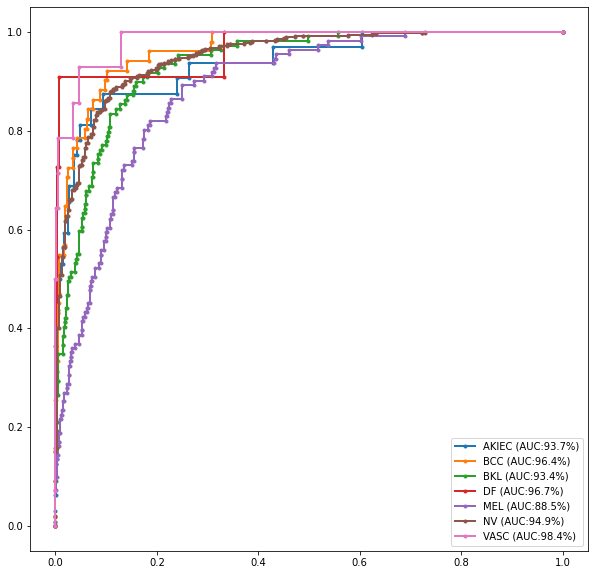

In [ ]:
ohe = OneHotEncoder(sparse=False)
y_test_ohe = ohe.fit_transform(test_labels.reshape(-1,1))
prediction = pred_sum

fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
for i, c_all in enumerate(class_names):
    tpr, fpr, thresh = roc_curve(y_true=y_test_ohe[:, i], y_score=prediction[:, i])
    auc_roc = roc_auc_score(y_true=y_test_ohe[:, i], y_score=prediction[:, i]) # 각 라벨에 대한 auc값을 구함.
    ax1.plot(tpr, fpr, '.-', label='{} (AUC:{:2.1%})'.format(c_all, auc_roc), lw=2)
ax1.legend()